In [129]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

data_input = {}
# 경로 나중에 바꿔야 된다. 
import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        data_input[filename] = pd.read_csv(os.path.join(dirname, filename))
print(data_input)

{'sales_train.csv':                date  date_block_num  shop_id  item_id  item_price  \
0        02.01.2013               0       59    22154      999.00   
1        03.01.2013               0       25     2552      899.00   
2        05.01.2013               0       25     2552      899.00   
3        06.01.2013               0       25     2554     1709.05   
4        15.01.2013               0       25     2555     1099.00   
...             ...             ...      ...      ...         ...   
2935844  10.10.2015              33       25     7409      299.00   
2935845  09.10.2015              33       25     7460      299.00   
2935846  14.10.2015              33       25     7459      349.00   
2935847  22.10.2015              33       25     7440      299.00   
2935848  03.10.2015              33       25     7460      299.00   

         item_cnt_day  
0                 1.0  
1                 1.0  
2                -1.0  
3                 1.0  
4                 1.0  
...    

In [130]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [131]:
train_data_origin = data_input['sales_train.csv']
item_categories_origin = data_input['item_categories.csv']
shop_origin = data_input['shops.csv']
items_origin = data_input['items.csv']
test_data_origin = data_input['test.csv']
del data_input['sample_submission.csv']

In [132]:
del data_input

In [133]:
train_data = pd.DataFrame(train_data_origin)

In [134]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [135]:
anomal_count = train_data['item_cnt_day'].map(lambda x : x < 0.0)
anomal_count = train_data[anomal_count]
print(anomal_count)

               date  date_block_num  shop_id  item_id  item_price  \
2        05.01.2013               0       25     2552       899.0   
148      23.01.2013               0       25     2321       999.0   
175      07.01.2013               0       25     2199      1449.0   
807      02.01.2013               0       25     2330       599.0   
1041     13.01.2013               0       25     5034      1989.0   
...             ...             ...      ...      ...         ...   
2934243  26.10.2015              33       25     3917       449.0   
2934462  18.10.2015              33       25     4896      6398.0   
2935263  05.10.2015              33       25    10039       249.0   
2935643  16.10.2015              33       25     7893      2990.0   
2935779  07.10.2015              33       25     7087       999.0   

         item_cnt_day  
2                -1.0  
148              -1.0  
175              -1.0  
807              -1.0  
1041             -1.0  
...               ...  
293

0 0 1
0 1 2
1 0 3
1 1 4
2 0 5


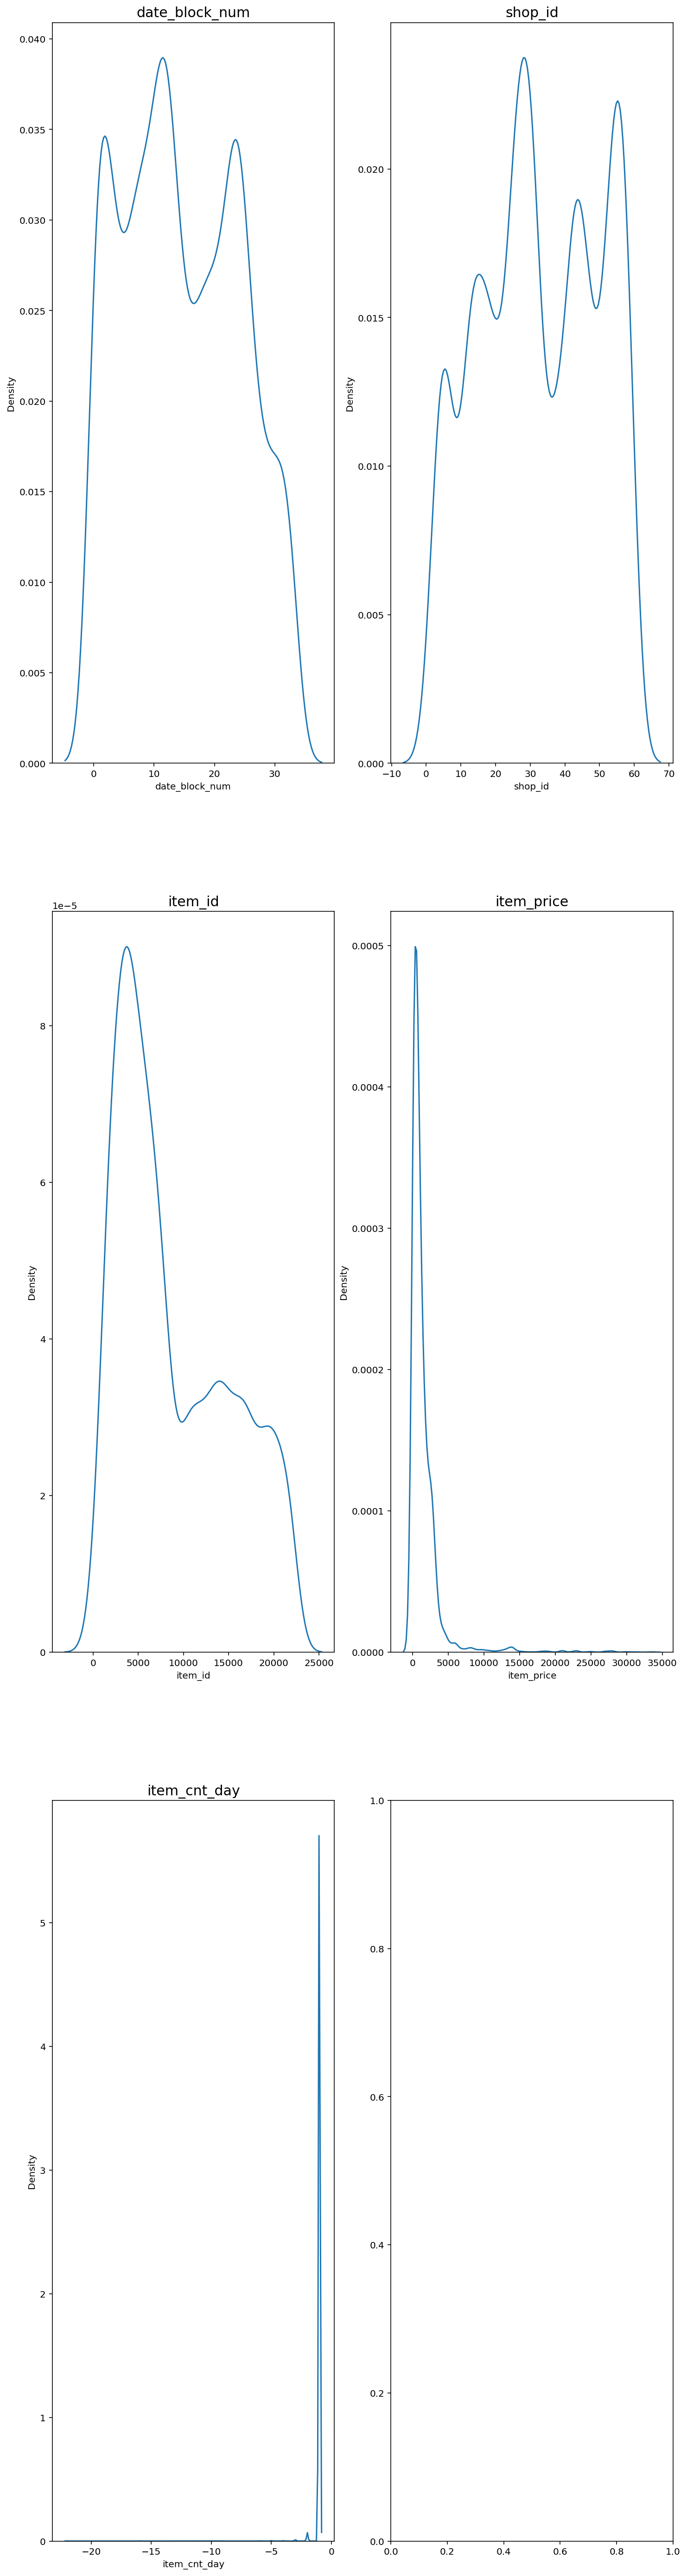

In [136]:
fig, ax = plt.subplots(3,2,figsize = (12,50))

count = 1
for row in range(3) :
    for col in range(2) :
        print(row,col,count)
        sns.kdeplot(anomal_count[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 6 :
            break

하루 판매량이 -인 값들을 모아서 혹시 각 값 간의 상관관계(ex: 특정 품목에서 유독 하루 매출량 에러가 난다거나)가 있는지 살펴봤는데, 특정 item id에 살짝 몰려 있는 것과, 하루 판매량이 -1부터 -5정도까지 다양하게 존재한다는 것을 알게 되었다. 첫번째로는 어떤 item id에서 판매량이 오류가 났는지 좀 더 살펴볼 예정이고, 두번째로는 결측치나 마찬가지인 이상값이 아닌 왠지 입력과정에서 부호가 뒤바뀌어서 들어갔을 가능성을 생각할 수 있게 되었다. 그래서 다음과 같은 작업을 해보려고 한다. 
1. 어떤 상품에서 하루 판매량 오류가 가장 많이 일어났나
2. 1이 파악된 후에 이상치의 부호를 바로잡아 정상값으로 되돌리자.

In [137]:
print(anomal_count.groupby('item_cnt_day').count().sort_values(['item_cnt_day'],ascending=False))
anomal_item = anomal_count.groupby('item_id').count().sort_values(['date'], ascending=False)
print(anomal_item)


              date  date_block_num  shop_id  item_id  item_price
item_cnt_day                                                    
-1.0          7252            7252     7252     7252        7252
-2.0            78              78       78       78          78
-3.0            14              14       14       14          14
-4.0             3               3        3        3           3
-5.0             4               4        4        4           4
-6.0             2               2        2        2           2
-9.0             1               1        1        1           1
-16.0            1               1        1        1           1
-22.0            1               1        1        1           1
         date  date_block_num  shop_id  item_price  item_cnt_day
item_id                                                         
2331       56              56       56          56            56
3734       41              41       41          41            41
1915       32            

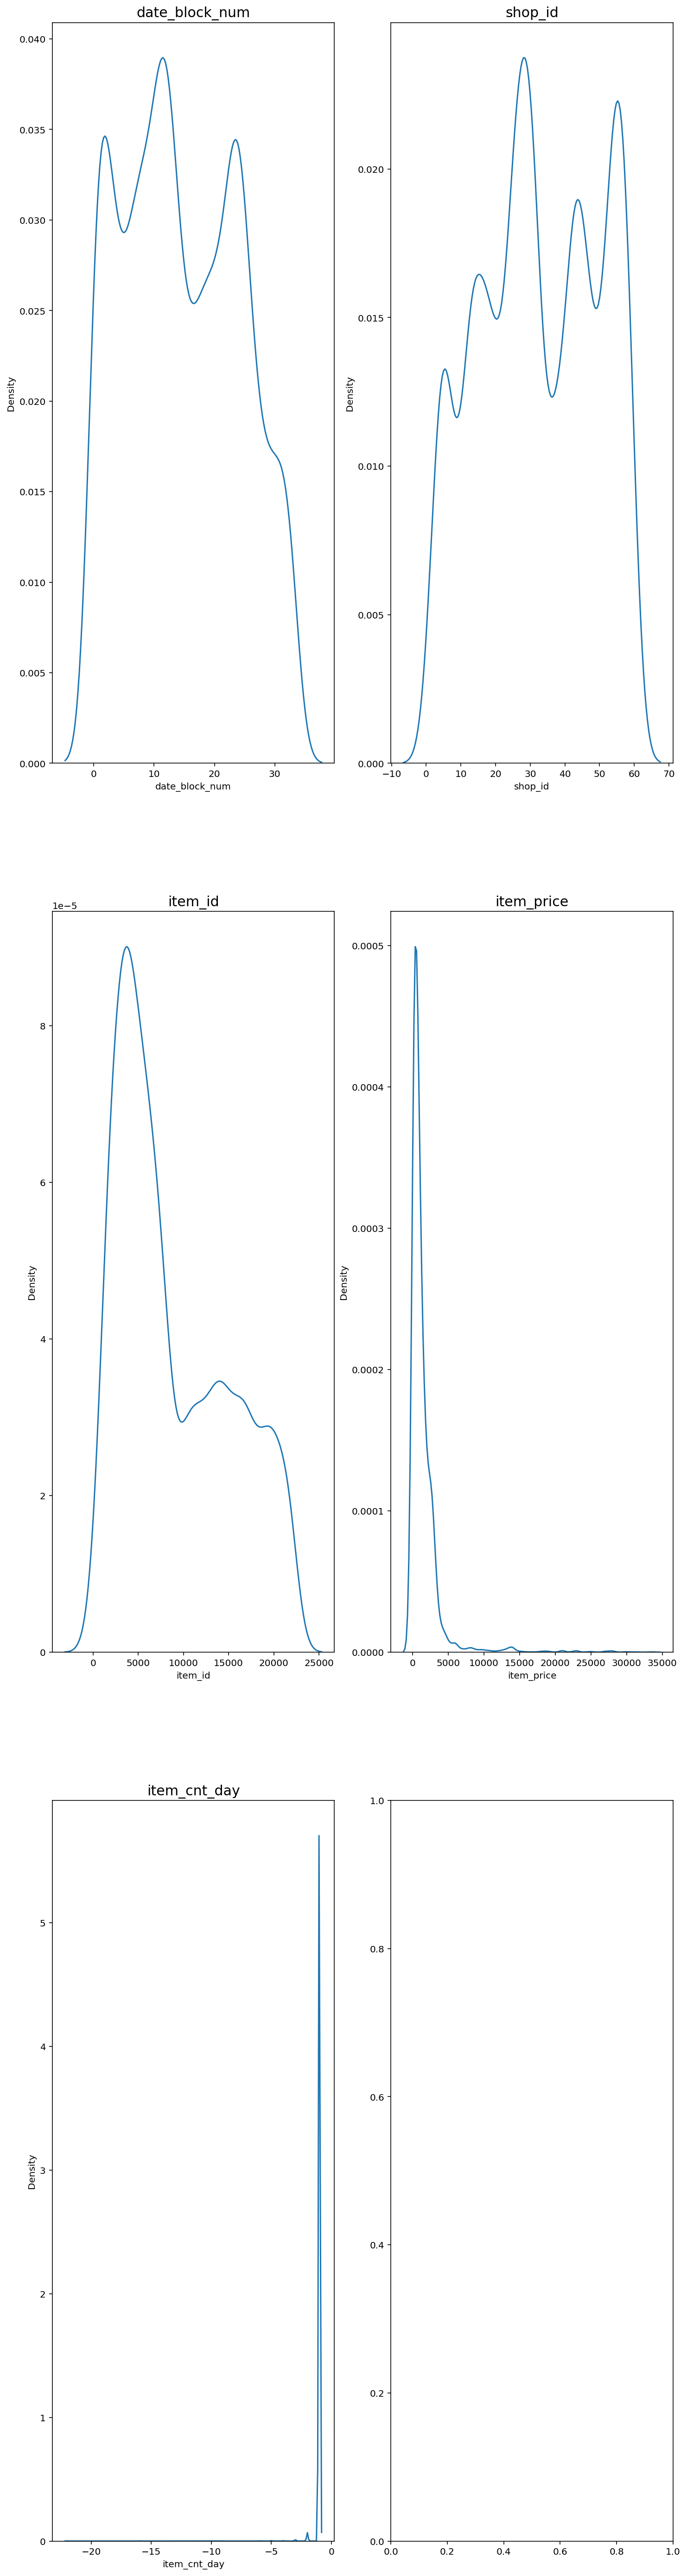

In [138]:
fig, ax = plt.subplots(3,2,figsize = (12,50))

count = 1
for row in range(3) :
    for col in range(2) :
        sns.kdeplot(anomal_count[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 6 :
            break

In [139]:
print(anomal_item.describe())
anomal_item_over_75 = anomal_item[anomal_item.apply(lambda x : x['date'] > 2, axis = 1)]

              date  date_block_num      shop_id   item_price  item_cnt_day
count  3511.000000     3511.000000  3511.000000  3511.000000   3511.000000
mean      2.095130        2.095130     2.095130     2.095130      2.095130
std       2.780899        2.780899     2.780899     2.780899      2.780899
min       1.000000        1.000000     1.000000     1.000000      1.000000
25%       1.000000        1.000000     1.000000     1.000000      1.000000
50%       1.000000        1.000000     1.000000     1.000000      1.000000
75%       2.000000        2.000000     2.000000     2.000000      2.000000
max      56.000000       56.000000    56.000000    56.000000     56.000000


이렇게 '판매량'에 대한 '마이너스'로 이상치를 가지고 있는 데이터들의 분석을 해보았다. 그런데 중복적으로 이상치가 들어오는 아이디는 따로 분류할 필요가 있어보인다. 상위 75퍼센트의 값을 모아서 확인해보니 4번 이상 마이너스값을 가진 아이디들을 따로 뽑아서 후에 데이터 분석에 활용할 예정이다. 

In [140]:
anomal_item_id_list = anomal_item[anomal_item.apply(lambda x : x['date'] > 3, axis = 1)]
print(anomal_item_id_list)
#anomal_item_id_list = anomal_item_id_list['item_id']
print(anomal_item_id_list.describe())
anomal_item_id_list = anomal_item_id_list.index
anomal_item_id_list = anomal_item_id_list.drop_duplicates()

         date  date_block_num  shop_id  item_price  item_cnt_day
item_id                                                         
2331       56              56       56          56            56
3734       41              41       41          41            41
1915       32              32       32          32            32
5672       31              31       31          31            31
16787      27              27       27          27            27
...       ...             ...      ...         ...           ...
11497       4               4        4           4             4
18168       4               4        4           4             4
3738        4               4        4           4             4
18344       4               4        4           4             4
7806        4               4        4           4             4

[422 rows x 5 columns]
             date  date_block_num     shop_id  item_price  item_cnt_day
count  422.000000      422.000000  422.000000  422.000000  

이제 마이너스로 나온 판매량을 양의 값으로 보정할 때가 왔다. 

In [141]:
train_data = pd.DataFrame(train_data_origin)
train_data['item_cnt_day'] = train_data['item_cnt_day'].apply(lambda x : abs(x))
print(len(train_data[train_data['item_cnt_day'].apply(lambda x : x < 0)]))

0


일단 데이터에 대해서 아무것도 모른다고 치고 데이터의 분포부터 알아보자. Fundamentals 17번 노드의 Anomaly Detection에 나온 통계적 분석 방법을 사용할 것이다. 이를 통해서 outlier와 novelities를 구분하려고 한다. 
먼저 데이터가 정규분포를 따르는지 파악하기에 앞서, 데이터를 분석하기 위해 여러 기준을 두어 범주로 묶어 분석하려고 한다. 
1. 각 아이템별 판매 추이
    - 해당 아이템의 전체적인 판매 흐름이 어떻게 되는지 알아보려고 한다.
2. 각 가게별 판매 추이
    - 특정 가게에 따라 잘 나가고 안 나가는 물품이 있을 것이다.(가게의 위치, 진열 특성, 평판 등의 이유로) 이 분석을 통해 `가게와 특정 물건의 판매 추이가 관련 있는지` 살펴보려고 한다. 
3. 각 년도별 판매 추이 
    - 사실 2015년은 메르스가 유행했던 시절이다. 러시아 사람들이 공공보건을 잘 지켰을 지는 모르겠지만 판매품들은 대부분 소프트웨어와 하드웨어와 관련된 제품들이다. 이에 `년도와 판매 추이의 관련성`이 존재하는지 증명하려고 한다.  

## 각 아이템별 판매 추이
먼저 학습 데이터를 id에 의해 하나로 묶는다.단 제일 많이 팔린 상위 n개의 물품에 대해서 이상치를 살펴볼 예정이다. 이들을 대표값으로 삼아서, 판매량과 상관관계가 있는 차원을 찾으려고 한다.

In [144]:
train_data['date'] = pd.to_datetime(train_data["date"])
train_data = train_data.sort_values(by = ['date'])
items = train_data.groupby(['item_id'])['item_cnt_day'].sum().sort_values(ascending=False)
print(items.head())
print(items.describe())

item_id
20949    187678.0
2808      17265.0
3732      16710.0
17717     15830.0
5822      14529.0
Name: item_cnt_day, dtype: float64
count     21807.000000
mean        167.986793
std        1367.060556
min           1.000000
25%           7.000000
50%          34.000000
75%         124.000000
max      187678.000000
Name: item_cnt_day, dtype: float64


In [90]:
train_data_with_minus = pd.DataFrame(train_data_origin)
print(train_data_with_minus['item_cnt_day'].describe())

count    2.935849e+06
mean     1.247778e+00
std      2.616391e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64


In [96]:
items_cnt_over_mean = items[items.apply(lambda x : x > 168.0)].index
print(items_cnt_over_mean)


Int64Index([20949,  2808,  3732, 17717,  5822,  3734,  6675,  3731,  1855,
            16787,
            ...
             6568,  5577,  1874, 18388,  2484,  8133,   325, 16112, 13444,
            18358],
           dtype='int64', name='item_id', length=4385)


예를 들어 가장 많이 팔린 `20949`번의 전체 판매 추이를 그래프로 그려보려고 한다.

In [145]:
best_item_record = train_data[train_data.apply(lambda x : x['item_id'] == 20949, axis = 1)]
print(best_item_record)

              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
512404  2013-01-05               4        7    20949         5.0           3.0
463114  2013-01-05               4       41    20949         5.0           1.0
513152  2013-01-05               4       13    20949         3.0           2.0
442919  2013-01-05               4       26    20949         5.0           1.0
520615  2013-01-05               4       43    20949         5.0           3.0
...            ...             ...      ...      ...         ...           ...
2929539 2015-12-10              33       21    20949         5.0           9.0
2910279 2015-12-10              33       14    20949         5.0           2.0
2905812 2015-12-10              33       53    20949         5.0           6.0
2915946 2015-12-10              33        5    20949         5.0           1.0
2898358 2015-12-10              33       58    20949         5.0           2.0

[31340 rows x 6 columns]


In [146]:
print(len(best_item_record) == len(best_item_record['date'].unique()))

False


              date  item_cnt_day
512404  2013-01-05           3.0
463114  2013-01-05           1.0
513152  2013-01-05           2.0
442919  2013-01-05           1.0
520615  2013-01-05           3.0
...            ...           ...
2929539 2015-12-10           9.0
2910279 2015-12-10           2.0
2905812 2015-12-10           6.0
2915946 2015-12-10           1.0
2898358 2015-12-10           2.0

[31340 rows x 2 columns]


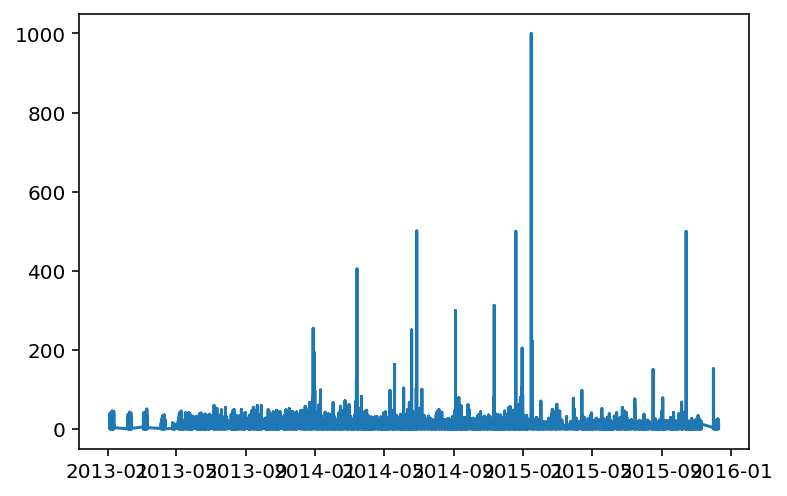

In [147]:
best_item_for_graph = best_item_record.groupby(['date']).sum(['item_cnt_day'])
print(best_item_record[['date','item_cnt_day']])
plt.plot(best_item_record['date'],best_item_record['item_cnt_day'])
plt.show()
#print(best_item_record['item_cnt_day'])

그래프를 보아하니 특정 날의 값이 튀는것 같다. 그렇다면 두 번째로 잘 팔린 아이템의 추이 그래프도 함께 그려보자. 

              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
47518   2013-01-01               0       15     2808       999.0           2.0
18429   2013-01-01               0       28     2808       999.0           2.0
28875   2013-01-01               0       27     2808       999.0           1.0
10116   2013-01-01               0       19     2808       999.0           2.0
81075   2013-01-01               0       54     2808       999.0           3.0
...            ...             ...      ...      ...         ...           ...
2727314 2015-12-07              30       18     2808      1499.0           1.0
2872533 2015-12-09              32       37     2808      1499.0           1.0
2901938 2015-12-10              33       48     2808      1499.0           1.0
2924805 2015-12-10              33       26     2808      1499.0           1.0
2910449 2015-12-10              33       15     2808      1499.0           1.0

[7479 rows x 6 columns]
              date  item_cn

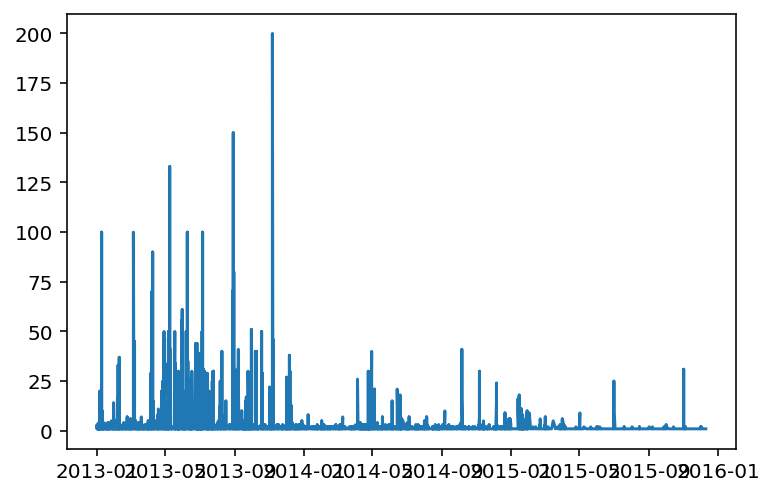

In [149]:
sec_best_item_record = train_data[train_data.apply(lambda x : x['item_id'] == 2808, axis = 1)]
print(sec_best_item_record)
sec_best_item_for_graph = sec_best_item_record.groupby(['date']).sum(['item_cnt_day'])
print(sec_best_item_record[['date','item_cnt_day']])
plt.plot(sec_best_item_record['date'],sec_best_item_record['item_cnt_day'])
plt.show()

              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
978066  2013-01-10               9       52     3732     2573.00           5.0
1013723 2013-01-10               9       10     3732     2184.00           1.0
1009906 2013-01-10               9       15     3732     2599.00           4.0
940037  2013-01-10               9       42     3732     2599.00           6.0
972678  2013-01-10               9       43     3732     2599.00           4.0
...            ...             ...      ...      ...         ...           ...
2825693 2015-12-08              31       25     3732     3399.00           1.0
2803852 2015-12-08              31       15     3732     3399.00           1.0
2866949 2015-12-09              32       10     3732     2651.44           1.0
2866027 2015-12-09              32        7     3732     3399.00           1.0
2862364 2015-12-09              32        3     3732     3399.00           1.0

[6475 rows x 6 columns]
              date  item_cn

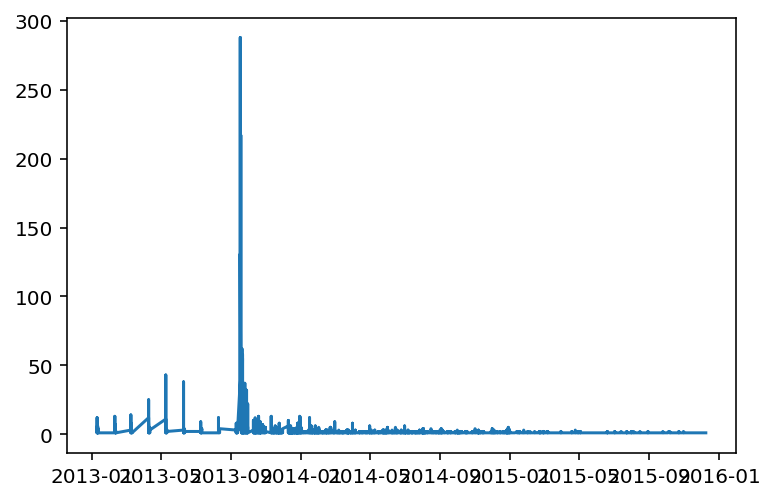

In [150]:
third_best_item_record = train_data[train_data.apply(lambda x : x['item_id'] == 3732, axis = 1)]
print(third_best_item_record)
third_best_item_for_graph = third_best_item_record.groupby(['date']).sum(['item_cnt_day'])
print(third_best_item_record[['date','item_cnt_day']])
plt.plot(third_best_item_record['date'],third_best_item_record['item_cnt_day'])
plt.show()

              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
56160   2013-01-01               0        7    17717       499.0           1.0
148557  2013-01-02               1       14    17717       999.0           1.0
144940  2013-01-02               1       18    17717       399.0           1.0
313241  2013-01-03               2       29    17717      1249.0           2.0
290547  2013-01-03               2       22    17717       970.0           2.0
...            ...             ...      ...      ...         ...           ...
2930740 2015-12-10              33       22    17717      1099.5           2.0
2923947 2015-12-10              33       25    17717       999.0           1.0
2899229 2015-12-10              33       59    17717       500.0           1.0
2929837 2015-12-10              33       24    17717       188.0           1.0
2916064 2015-12-10              33        5    17717      2599.0           1.0

[9067 rows x 6 columns]
              date  item_cn

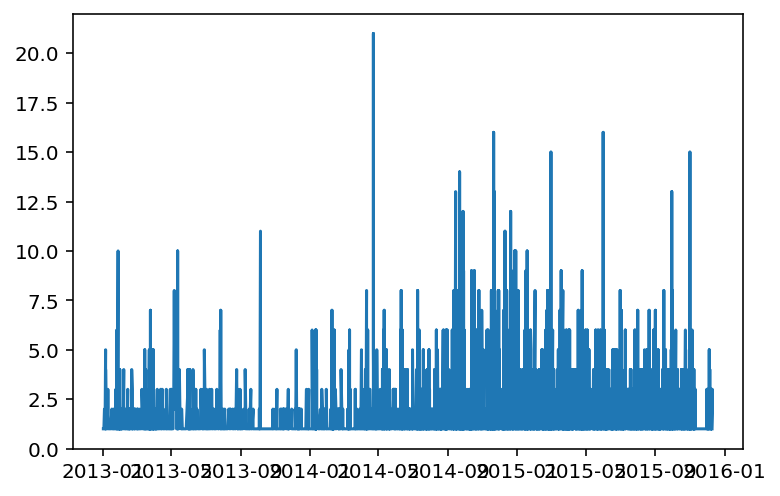

In [152]:
forth_best_item_record = train_data[train_data.apply(lambda x : x['item_id'] == 17717, axis = 1)]
print(forth_best_item_record)
forth_best_item_for_graph = forth_best_item_record.groupby(['date']).sum(['item_cnt_day'])
print(forth_best_item_record[['date','item_cnt_day']])
plt.plot(forth_best_item_record['date'],forth_best_item_record['item_cnt_day'])
plt.show()

              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
47408   2013-01-01               0       15     5822       999.0           2.0
101039  2013-01-01               0       51     5822       884.0           2.0
49783   2013-01-01               0       18     5822       999.0           2.0
82129   2013-01-01               0       54     5822       999.0           3.0
117080  2013-01-02               1       50     5822       999.0           1.0
...            ...             ...      ...      ...         ...           ...
2908065 2015-12-10              33       15     5822      1149.0           1.0
2925751 2015-12-10              33       31     5822      1149.0           1.0
2923179 2015-12-10              33       28     5822      1149.0           1.0
2901383 2015-12-10              33       48     5822      1149.0           1.0
2934311 2015-12-10              33       25     5822      1149.0           1.0

[9408 rows x 6 columns]
              date  item_cn

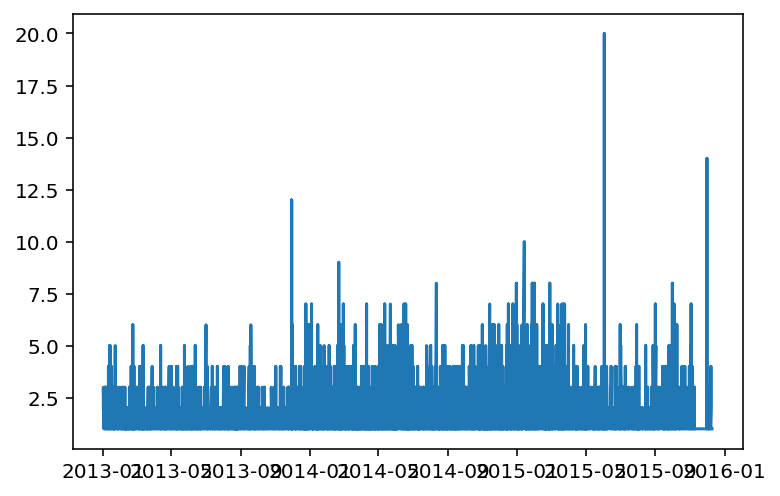

In [153]:
fifth_best_item_record = train_data[train_data.apply(lambda x : x['item_id'] == 5822, axis = 1)]
print(fifth_best_item_record)
fifth_best_item_for_graph = fifth_best_item_record.groupby(['date']).sum(['item_cnt_day'])
print(fifth_best_item_record[['date','item_cnt_day']])
plt.plot(fifth_best_item_record['date'],fifth_best_item_record['item_cnt_day'])
plt.show()

그래프를 한번에 그려보자! 역대 잘 팔린 물품 5위까지의 물건들의 시간 추이를 그래프로 그려보자. 

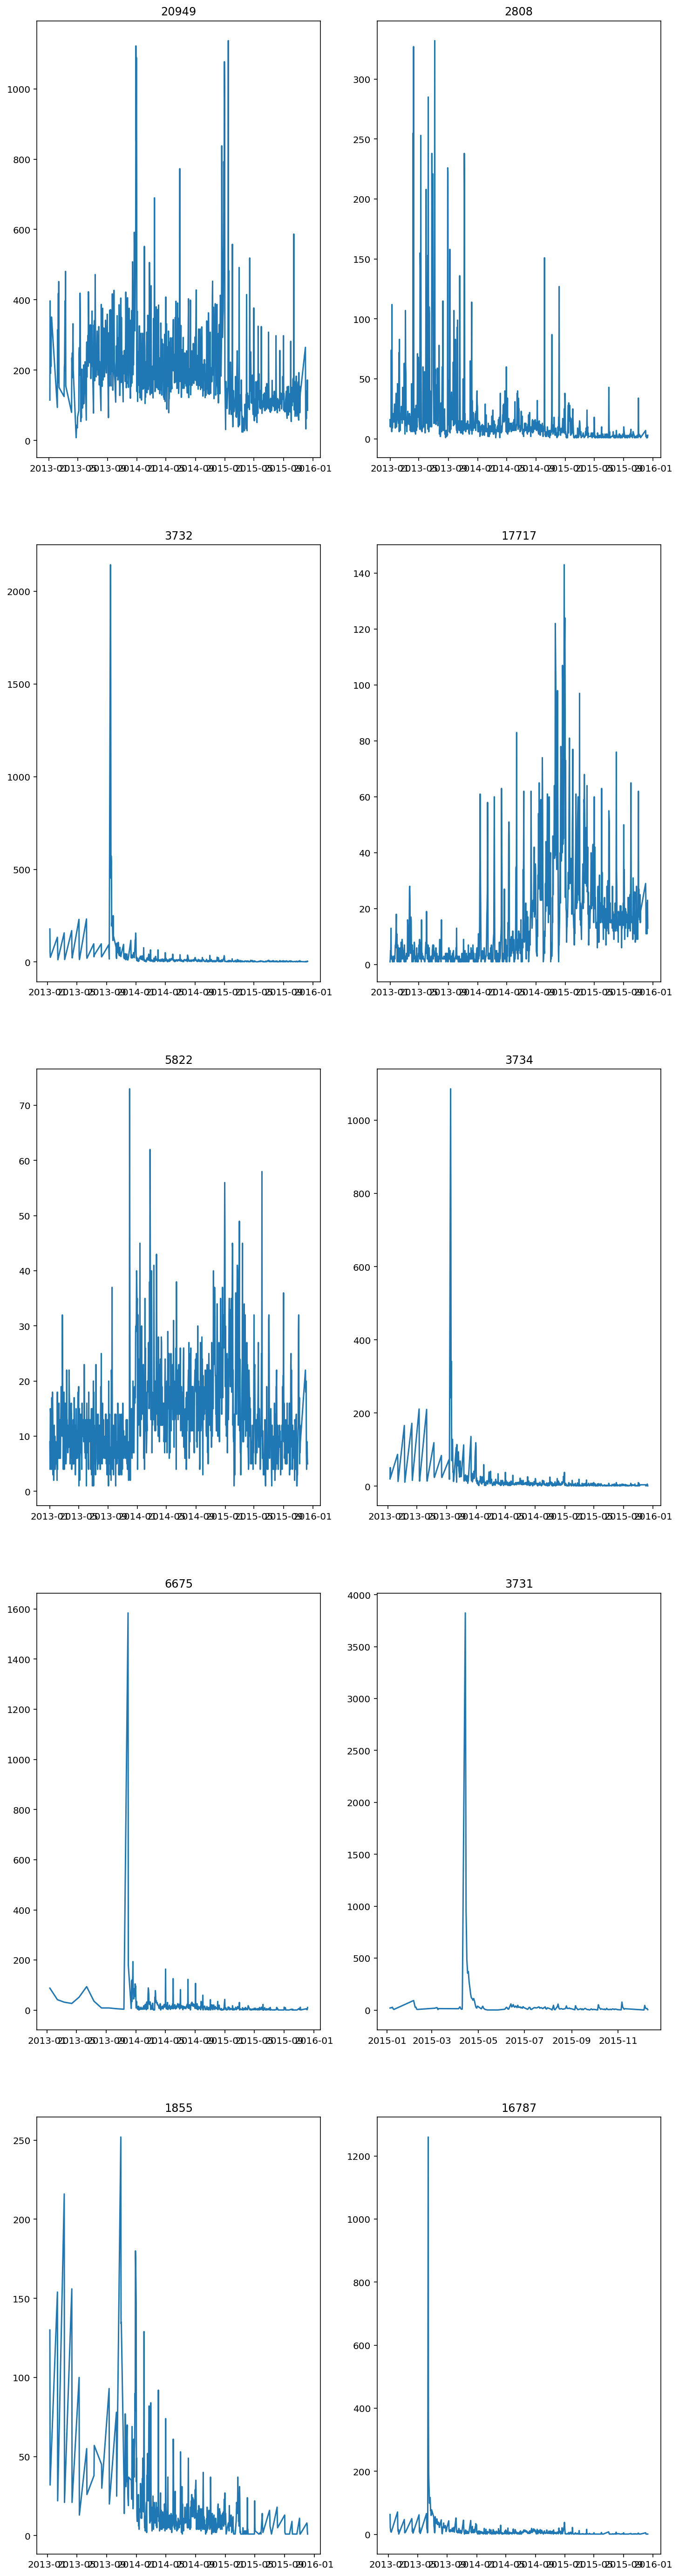

In [161]:
fig, ax = plt.subplots(5,2,figsize = (12,50))

#items_cnt_over_mean
count = 0
for row in range(5) :
    for col in range(2) :
        item_record = train_data[train_data.apply(lambda x : x['item_id'] == items_cnt_over_mean[count] , axis = 1)]
        item_for_graph = item_record.groupby(['date']).sum(['item_cnt_day'])
        #print(item_for_graph)
        ax[row,col].plot(item_for_graph.index, item_for_graph['item_cnt_day'])
        ax[row,col].set_title(items_cnt_over_mean[count])
        #ax[row][col].set_title(items_cnt_over_mean[count], fontsize=15)
        count += 1
        if count == 10 :
            break

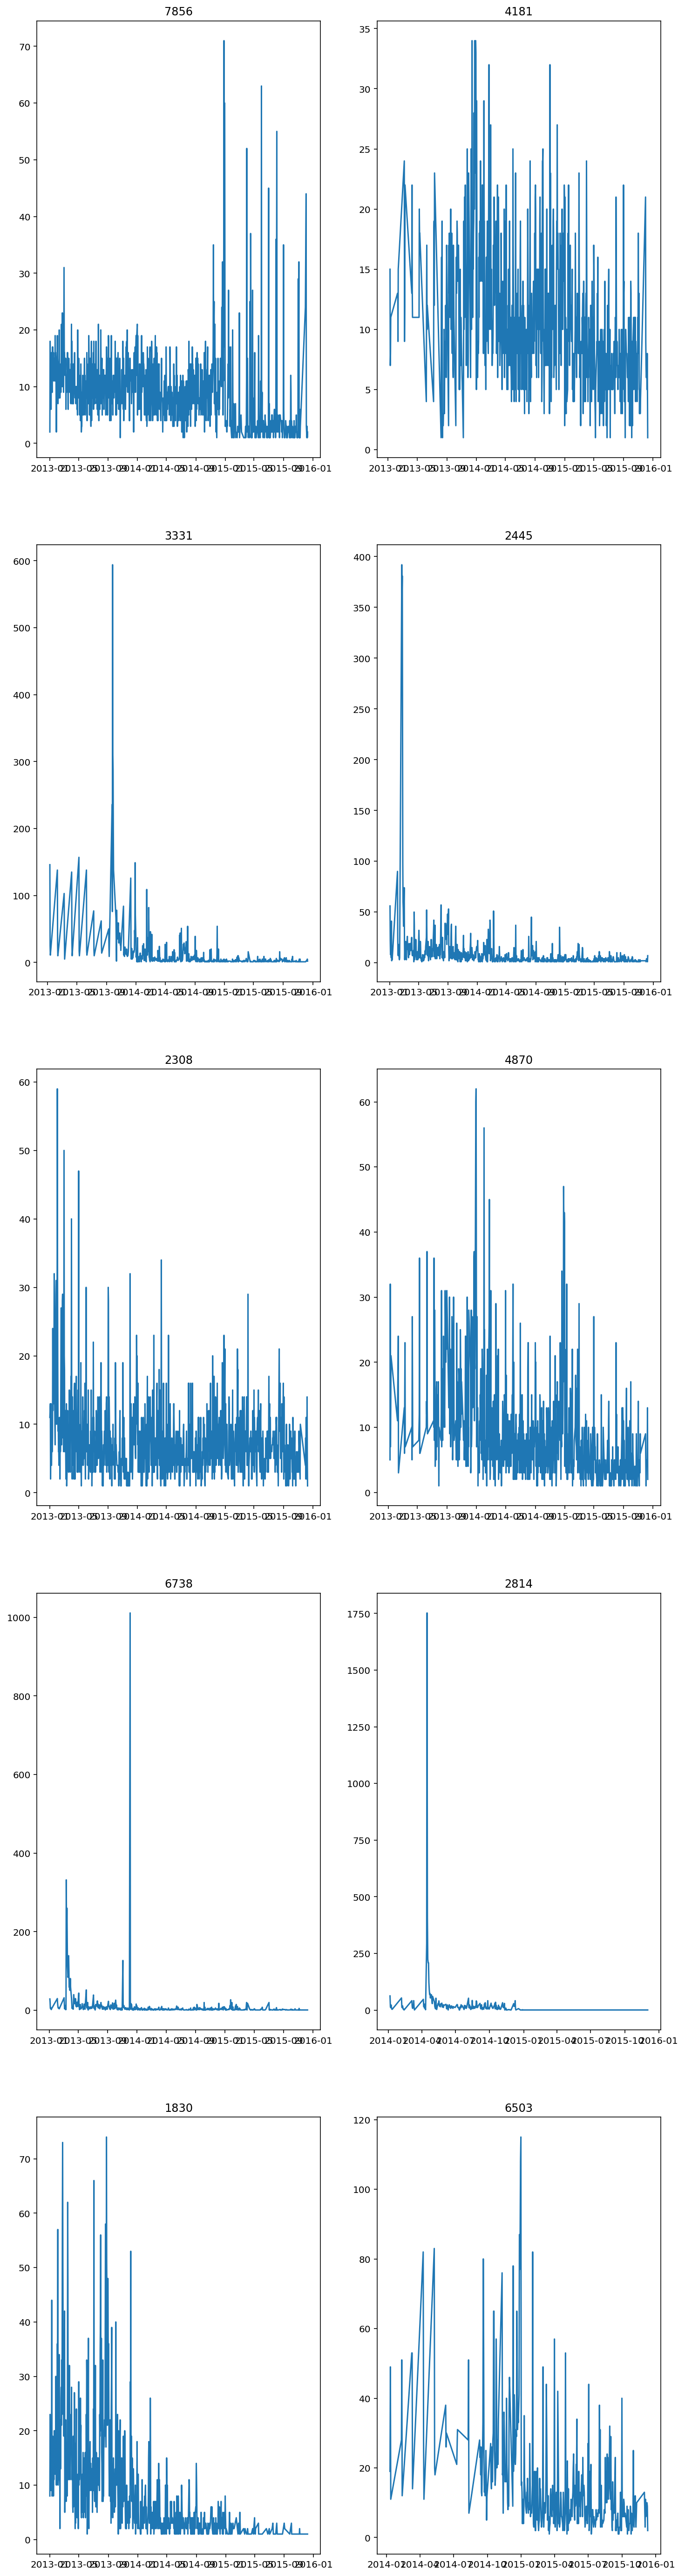

In [162]:
fig, ax = plt.subplots(5,2,figsize = (12,50))

#items_cnt_over_mean
count = 10
for row in range(5) :
    for col in range(2) :
        item_record = train_data[train_data.apply(lambda x : x['item_id'] == items_cnt_over_mean[count] , axis = 1)]
        item_for_graph = item_record.groupby(['date']).sum(['item_cnt_day'])
        #print(item_for_graph)
        ax[row,col].plot(item_for_graph.index, item_for_graph['item_cnt_day'])
        ax[row,col].set_title(items_cnt_over_mean[count])
        #ax[row][col].set_title(items_cnt_over_mean[count], fontsize=15)
        count += 1
        if count == 20 :
            break